## Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods
Source: [https://github.com/dylan-slack/Fooling-LIME-SHAP](https://github.com/dylan-slack/Fooling-LIME-SHAP)
Paper: [Fooling LIME and SHAP: Adversarial Attacks on Post hoc Explanation Methods](https://arxiv.org/pdf/1911.02508.pdf)

In [1]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px
import matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from  matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
!git clone https://github.com/dylan-slack/Fooling-LIME-SHAP.git -quite

In [3]:
import sys
sys.path.insert(1, '/kaggle/working/Fooling-LIME-SHAP')

In [4]:
import warnings
warnings.filterwarnings('ignore') 

from adversarial_models import * 
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap
from copy import deepcopy

In [5]:
def get_and_preprocess_compas_data(params):
    """Handle processing of COMPAS according to: https://github.com/propublica/compas-analysis

    Parameters
    ----------
    params : Params
    Returns
    ----------
    Pandas data frame X of processed data, np.ndarray y, and list of column names
    """
    PROTECTED_CLASS = params.protected_class
    UNPROTECTED_CLASS = params.unprotected_class
    POSITIVE_OUTCOME = params.positive_outcome
    NEGATIVE_OUTCOME = params.negative_outcome

    compas_df = pd.read_csv("./Fooling-LIME-SHAP/data/compas-scores-two-years.csv", index_col=0)
    compas_df = compas_df.loc[(compas_df['days_b_screening_arrest'] <= 30) &
                              (compas_df['days_b_screening_arrest'] >= -30) &
                              (compas_df['is_recid'] != -1) &
                              (compas_df['c_charge_degree'] != "O") &
                              (compas_df['score_text'] != "NA")]

    compas_df['length_of_stay'] = (
                pd.to_datetime(compas_df['c_jail_out']) - pd.to_datetime(compas_df['c_jail_in'])).dt.days
    X = compas_df[['age', 'two_year_recid', 'c_charge_degree', 'race', 'sex', 'priors_count', 'length_of_stay']]

    # if person has high score give them the _negative_ model outcome
    y = np.array([NEGATIVE_OUTCOME if score == 'High' else POSITIVE_OUTCOME for score in compas_df['score_text']])
    sens = X.pop('race')

    # assign African-American as the protected class
    X = pd.get_dummies(X)
    sensitive_attr = np.array(pd.get_dummies(sens).pop('African-American'))
    X['race'] = sensitive_attr

    # make sure everything is lining up
    assert all((sens == 'African-American') == (X['race'] == PROTECTED_CLASS))
    cols = [col for col in X]

    return X, y, cols


def get_and_preprocess_cc(params):
    """"Handle processing of Communities and Crime.  We exclude rows with missing values and predict
    if the violent crime is in the 50th percentile.
    Parameters
    ----------
    params : Params
    Returns:
    ----------
    Pandas data frame X of processed data, np.ndarray y, and list of column names
    """
    PROTECTED_CLASS = params.protected_class
    UNPROTECTED_CLASS = params.unprotected_class
    POSITIVE_OUTCOME = params.positive_outcome
    NEGATIVE_OUTCOME = params.negative_outcome

    X = pd.read_csv("./Fooling-LIME-SHAP/data/communities_and_crime_new_version.csv", index_col=0)

    # everything over 50th percentil gets negative outcome (lots of crime is bad)
    high_violent_crimes_threshold = 50
    y_col = 'ViolentCrimesPerPop numeric'

    X = X[X[y_col] != "?"]
    X[y_col] = X[y_col].values.astype('float32')

    # just dump all x's that have missing values 
    cols_with_missing_values = []
    for col in X:
        if len(np.where(X[col].values == '?')[0]) >= 1:
            cols_with_missing_values.append(col)

    y = X[y_col]
    y_cutoff = np.percentile(y, high_violent_crimes_threshold)
    X = X.drop(
        cols_with_missing_values + ['communityname string', 'fold numeric', 'county numeric', 'community numeric',
                                    'state numeric'] + [y_col], axis=1)

    # setup ys
    cols = [c for c in X]
    y = np.array([NEGATIVE_OUTCOME if val > y_cutoff else POSITIVE_OUTCOME for val in y])

    return X, y, cols

In [6]:
# Get the data set and do some preprocessing
params = Params("./Fooling-LIME-SHAP/model_configurations/experiment_params.json") 
np.random.seed(params.seed)
X, y, cols = get_and_preprocess_compas_data(params)

# Add a random column -- this is what we'll have LIME/SHAP explain.
X['unrelated_column'] = np.random.choice([0,1],size=X.shape[0])
features = [c for c in X]

categorical_feature_name = ['two_year_recid', 'c_charge_degree_F', 'c_charge_degree_M',\
                            'sex_Female', 'sex_Male', 'race', 'unrelated_column']

categorical_feature_indcs = [features.index(c) for c in categorical_feature_name]

race_indc = features.index('race')
unrelated_indcs = features.index('unrelated_column')
X = X.values

In [7]:

class racist_model_f:
    # Decision rule: classify negatively if race is black
    def predict(self,X):
        return np.array([params.negative_outcome if x[race_indc] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)
    
class innocuous_model_psi:
    # Decision rule: classify according to randomly drawn column 'unrelated column'
    def predict(self,X):
        return np.array([params.negative_outcome if x[unrelated_indcs] > 0 else params.positive_outcome for x in X])

    def predict_proba(self, X): 
        return one_hot_encode(self.predict(X))

    def score(self, X,y):
        return np.sum(self.predict(X)==y) / len(X)

In [8]:
# Split the data and normalize
xtrain,xtest,ytrain,ytest = train_test_split(X,y)
xtest_not_normalized = deepcopy(xtest)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

# Train the adversarial model for LIME with f and psi 
adv_lime = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features, categorical_features=categorical_feature_indcs)

In [9]:
# Let's just look at a the first example in the test set
ex_indc = np.random.choice(xtest.shape[0])

# To get a baseline, we'll look at LIME applied to the biased model f
normal_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(),
                                                          discretize_continuous=False,
                                                          categorical_features=categorical_feature_indcs)

normal_exp = normal_explainer.explain_instance(xtest[ex_indc], racist_model_f().predict_proba).as_list()

print ("Explanation on biased f:\n",normal_exp[:3],"\n\n")

# Now, lets look at the explanations on the adversarial model 
adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain,feature_names=adv_lime.get_column_names(), 
                                                       discretize_continuous=False,
                                                       categorical_features=categorical_feature_indcs)

adv_exp = adv_explainer.explain_instance(xtest[ex_indc], adv_lime.predict_proba).as_list()

print ("Explanation on adversarial model:\n",adv_exp[:3],"\n")

print("Prediction fidelity: {0:3.2}".format(adv_lime.fidelity(xtest[ex_indc:ex_indc+1])))

Explanation on biased f:
 [('race=0', -0.9986343456272184), ('sex_Female=0', 2.0027981228433426e-05), ('unrelated_column=0', -1.7913202734343337e-05)] 


Explanation on adversarial model:
 [('unrelated_column=0', -0.9981443627773983), ('sex_Male=0', 0.0012015987966745123), ('two_year_recid=1', -0.0005130675716729507)] 

Prediction fidelity: 1.0


In [10]:
# Train the adversarial model
adv_shap = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).\
            train(xtrain, ytrain, feature_names=features)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

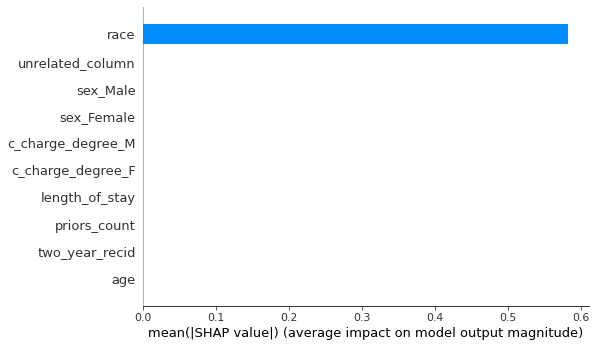

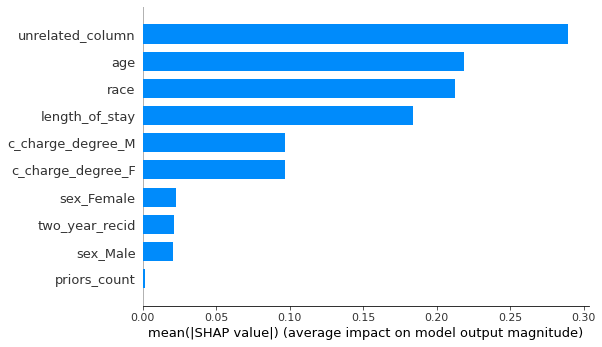

Fidelity: 1.0


In [11]:
# Set the background distribution for the shap explainer using kmeans
background_distribution = shap.kmeans(xtrain,10)

# Let's use the shap kernel explainer and grab a point to explain
to_examine = np.random.choice(xtest.shape[0])

# Explain the biased model
biased_kernel_explainer = shap.KernelExplainer(racist_model_f().predict, background_distribution)
biased_shap_values = biased_kernel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Explain the adversarial model
adv_kerenel_explainer = shap.KernelExplainer(adv_shap.predict, background_distribution)
adv_shap_values = adv_kerenel_explainer.shap_values(xtest[to_examine:to_examine+1])

# Plot it using SHAP's plotting features.
shap.summary_plot(biased_shap_values, feature_names=features, plot_type="bar")
shap.summary_plot(adv_shap_values, feature_names=features, plot_type="bar")

print ("Fidelity: {0:3.2}".format(adv_shap.fidelity(xtest[to_examine:to_examine+1])))

In [12]:
def Wasserstein_Dist(XX, YY):
  
    import numpy as np
    nx = len(XX)
    ny = len(YY)
    n = nx + ny

    XY = np.concatenate([XX,YY])
    X2 = np.concatenate([np.repeat(1/nx, nx), np.repeat(0, ny)])
    Y2 = np.concatenate([np.repeat(0, nx), np.repeat(1/ny, ny)])

    S_Ind = np.argsort(XY)
    XY_Sorted = XY[S_Ind]
    X2_Sorted = X2[S_Ind]
    Y2_Sorted = Y2[S_Ind]

    Res = 0
    E_CDF = 0
    F_CDF = 0
    power = 1

    for ii in range(0, n-2):
        E_CDF = E_CDF + X2_Sorted[ii]
        F_CDF = F_CDF + Y2_Sorted[ii]
        height = abs(F_CDF-E_CDF)
        width = XY_Sorted[ii+1] - XY_Sorted[ii]
        Res = Res + (height ** power) * width;  
 
    return Res

def WasserstainLIME2(X_input, model, num_perturb = 500, L_num_perturb = 100, kernel_width2 = 0.75, epsilon = 0.1):
    '''
    WasserstainLIME is a statistical version of LIME (local interpretable model-agnostic explanations) 
    in which instead of Euclidean distance, the ECDF-based distance is used.
    
    X_input: should be a numpy array that represents one point in a n-dimensional space.
    
    num_perturb: Is the number of perturbations that the algorithm uses.
    
    L_num_perturb: Is the number of perturbations in the local areas that the algorithm uses.
    
    kernel_width: Is the Kernel Width. When the decision space is very dynamic, the kernel width should be low like 0.2, 
    otherwise kernel with around 0.75 would be ideal.
    
    model: It is the trained model that can be for a classification or regression. 
    
    epsilon: It is used to normalize the WD values.
    
    '''
    
    X_input = (X_input - np.mean(X_input,axis=0)) / np.std(X_input,axis=0) #Standarization of data

    X_lime = np.random.normal(0,1,size=(num_perturb,X_input.shape[0]))
    
    Xi2 = np.zeros((L_num_perturb,X_input.shape[0]))
    
    for jj in range(X_input.shape[0]):
        Xi2[:,jj] = X_input[jj] + np.random.normal(0,0.05,L_num_perturb)

    y_lime2  = np.zeros((num_perturb,1))
    WD       = np.zeros((num_perturb,1))
    weights2 = np.zeros((num_perturb,1))
    
    for ind, ii in enumerate(X_lime):
        
        df2 = pd.DataFrame()
        
        for jj in range(X_input.shape[0]):
            temp1 = ii[jj] + np.random.normal(0,0.3,L_num_perturb)
            df2[len(df2.columns)] = temp1

        temp3 = model.predict(df2.to_numpy())

        y_lime2[ind] = np.mean(temp3)  # For classification: np.argmax(np.bincount(temp3))
        
        WD1 = np.zeros((X_input.shape[0],1))
        
        df2 = df2.to_numpy()
        
        for kk in range(X_input.shape[0]):
            #print( df2.shape)
            WD1[kk] = Wasserstein_Dist(Xi2[:,kk], df2[:,kk])
        
        #print(WD1)
        #print(ind)
        WD[ind] = sum(WD1)
        #print(WD)
    
        weights2[ind] = np.sqrt(np.exp(-((epsilon*WD[ind])**2)/(kernel_width2**2))) 
        #print(weights2[ind])
        
        del df2
    
    weights2 = weights2.flatten()
    #print(weights2)
    
    simpler_model2 = LinearRegression() 
    simpler_model2.fit(X_lime, y_lime2, sample_weight=weights2)
    y_linmodel2 = simpler_model2.predict(X_lime)
    y_linmodel2 = y_linmodel2 < 0.5 #Conver to binary class
    y_linmodel2 = y_linmodel2.flatten()
    
    return X_lime, y_lime2, weights2, y_linmodel2, simpler_model2.coef_.flatten()

In [13]:
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef1 = WasserstainLIME2(xtest[to_examine:to_examine+1].flatten(), 
                                                                      num_perturb = 2000, 
                                                                      kernel_width2 = 0.5, 
                                                                      L_num_perturb = 500,
                                                                      model = racist_model_f(), 
                                                                      epsilon = 0.3)



df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

df3['WDL'] = WLIME_Coef1
df3['feature_names'] = features

import plotly.express as px
fig = px.bar(df3, x='WDL', y='feature_names', orientation='h', color='feature_names')
fig.show()

In [14]:
X_lime, y_lime2, weights2, y_linmodel2, WLIME_Coef2 = WasserstainLIME2(xtest[to_examine:to_examine+1].flatten(), 
                                                                      num_perturb = 500, 
                                                                      kernel_width2 = 0.75, 
                                                                      model = adv_shap, 
                                                                      epsilon = 0.3)
#print(WLIME_Coef)

df3 = pd.DataFrame()
temp0 = np.zeros((2,2))

df3['WDL'] = WLIME_Coef2 
df3['feature_names'] = features

import plotly.express as px
fig = px.bar(df3, x='WDL', y='feature_names', orientation='h', color='feature_names')
fig.show()

In [15]:
adv_shap_values[0]

array([-0.21873746,  0.02125266,  0.0015837 , -0.18383946, -0.09685009,
       -0.09685009, -0.02246654, -0.02035048, -0.21228539,  0.28933381])

In [16]:
lime_features = ['priors_count', 'c_charge_degree_F','two_year_recid','sex_Male','length_of_stay','age','c_charge_degree_M','unrelated_column','sex_Female','race']

In [17]:
normal_exp
exp4 = []
for ii, jj in normal_exp:
    exp4.append(jj)
exp_racist = exp4[::-1]
exp_racist

[2.758851410141496e-07,
 4.896484804686421e-06,
 -8.072093428418658e-06,
 -9.045761477659396e-06,
 -9.645811751882923e-06,
 -1.0977768582945641e-05,
 -1.300641330657808e-05,
 -1.7913202734343337e-05,
 2.0027981228433426e-05,
 -0.9986343456272184]

In [18]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("SMILE","SHAP","LIME"),
                    horizontal_spacing = 0.1)

fig.add_trace(
    go.Bar(x=WLIME_Coef1, y=features, orientation='h', 
           marker=dict(color=np.argsort(WLIME_Coef1), coloraxis="coloraxis")),#, color=df3['feature_names']),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=biased_shap_values[0], y=features, orientation='h', 
           marker=dict(color=np.argsort(biased_shap_values[0]), coloraxis="coloraxis")),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=exp_racist, y=lime_features, orientation='h', 
           marker=dict(color=np.argsort(exp_racist), coloraxis="coloraxis")),
    row=1, col=3
)

fig.update_layout(height=600, width=1500, title_text="Comparing SHAP, LIME and SMILE against Adversarial Attack - Racist Model",
                  coloraxis=dict(colorscale='Bluered_r'), showlegend=False) # px.colors.sequential.Viridis
fig.show()

In [19]:
# adv_exp
exp3 = []
for ii, jj in adv_exp:
    exp3.append(jj)
exp_adv = exp3[::-1]
exp_adv

[-7.280598930616827e-05,
 -0.00018164896760443006,
 -0.00018354024072875124,
 -0.0003080079575628089,
 -0.0003248976438156429,
 -0.000337167643657034,
 -0.00041210902462883556,
 -0.0005130675716729507,
 0.0012015987966745123,
 -0.9981443627773983]

In [20]:
fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("SMILE","SHAP","LIME"),
                    horizontal_spacing = 0.1)

fig.add_trace(
    go.Bar(x=WLIME_Coef2, y=features, orientation='h', 
           marker=dict(color=np.argsort(WLIME_Coef2), coloraxis="coloraxis")),#, color=df3['feature_names']),
    row=1, col=1
)

fig.add_trace(
    go.Bar(x=np.array(adv_shap_values[0]), y=features, orientation='h', 
           marker=dict(color=np.argsort(adv_shap_values[0]), coloraxis="coloraxis")),
    row=1, col=2
)

fig.add_trace(
    go.Bar(x=exp_adv, y=features, orientation='h', 
           marker=dict(color=np.argsort(exp_adv), coloraxis="coloraxis")),
    row=1, col=3
)

fig.update_layout(height=600, width=1500, title_text="Comparing SHAP, LIME and SMILE against Adversarial Attack - Unrealated Feature",
                  coloraxis=dict(colorscale='Bluered_r'), showlegend=False) # px.colors.sequential.Viridis
fig.show()

In [21]:
def get_and_preprocess_german2(params):

    PROTECTED_CLASS = params.protected_class
    UNPROTECTED_CLASS = params.unprotected_class
    POSITIVE_OUTCOME = params.positive_outcome
    NEGATIVE_OUTCOME = params.negative_outcome

    X = pd.read_csv("./Fooling-LIME-SHAP/data/german_processed.csv")
    y = X["GoodCustomer"]

    X = X.drop(["GoodCustomer", "PurposeOfLoan"], axis=1)
    X['Gender'] = [1 if v == "Male" else 0 for v in X['Gender'].values]

    y = np.array([POSITIVE_OUTCOME if p == 1 else NEGATIVE_OUTCOME for p in y.values])

    return X, y, [c for c in X] 

In [22]:
"""
The experiment MAIN for GERMAN.
"""
import warnings

warnings.filterwarnings('ignore')

from adversarial_models import *
from utils import *
from get_data import *

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import lime
import lime.lime_tabular
import shap

from sklearn.cluster import KMeans

from copy import deepcopy

# Set up experiment parameters
params = Params("./Fooling-LIME-SHAP/model_configurations/experiment_params.json")
X, y, cols = get_and_preprocess_german2(params)

features = [c for c in X]

gender_indc = features.index('Gender')
loan_rate_indc = features.index('LoanRateAsPercentOfIncome')

X = X.values

xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.1)
ss = StandardScaler().fit(xtrain)
xtrain = ss.transform(xtrain)
xtest = ss.transform(xtest)

mean_lrpi = np.mean(xtrain[:, loan_rate_indc])

categorical = ['Gender', 'ForeignWorker', 'Single', 'HasTelephone', 'CheckingAccountBalance_geq_0',
               'CheckingAccountBalance_geq_200', 'SavingsAccountBalance_geq_100', 'SavingsAccountBalance_geq_500',
               'MissedPayments', 'NoCurrentLoan', 'CriticalAccountOrLoansElsewhere', 'OtherLoansAtBank',
               'OtherLoansAtStore', 'HasCoapplicant', 'HasGuarantor', 'OwnsHouse', 'RentsHouse', 'Unemployed',
               'YearsAtCurrentJob_lt_1', 'YearsAtCurrentJob_geq_4', 'JobClassIsSkilled']
categorical = [features.index(c) for c in categorical]


###
## The models f and psi for GERMAN.  We discriminate based on gender for f and consider loan rate % income for explanation
#

# the biased model 
class racist_model_f:
    # Decision rule: classify negative outcome if female
    def predict(self, X):
        return np.array([params.negative_outcome if x[gender_indc] < 0 else params.positive_outcome for x in X])

    def predict_proba(self, X):
        return one_hot_encode(self.predict(X))

    def score(self, X, y):
        return np.sum(self.predict(X) == y) / len(X)


# the display model with one unrelated feature
class innocuous_model_psi:
    # Decision rule: classify according to loan rate indc
    def predict_proba(self, X):
        return one_hot_encode(np.array(
            [params.negative_outcome if x[loan_rate_indc] > mean_lrpi else params.positive_outcome for x in X]))


##
###

# Train the adversarial model for LIME with f and psi 
adv_limeG = Adversarial_Lime_Model(racist_model_f(), innocuous_model_psi()).train(xtrain, ytrain,
                                                                                 feature_names=features,
                                                                                 perturbation_multiplier=30,
                                                                                 categorical_features=categorical)
adv_explainer = lime.lime_tabular.LimeTabularExplainer(xtrain, feature_names=adv_limeG.get_column_names(),
                                                       discretize_continuous=False,
                                                       categorical_features=categorical)

explanations_lime = []
for i in range(xtest.shape[0]):
    explanations_lime.append(adv_explainer.explain_instance(xtest[i], adv_lime.predict_proba).as_list())

# Display Results
print("LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:")
print(experiment_summary(explanations_lime, features))
print("Fidelity:", round(adv_limeG.fidelity(xtest), 2))

print('---------------------')
print('Beginning SHAP GERMAN Experiments....')
print('---------------------')

# Setup SHAP
background_distribution = KMeans(n_clusters=10, random_state=0).fit(xtrain).cluster_centers_
adv_shapG = Adversarial_Kernel_SHAP_Model(racist_model_f(), innocuous_model_psi()).train(xtrain, ytrain,
                                                                                        feature_names=features,
                                                                                        background_distribution=background_distribution,
                                                                                        rf_estimators=100,
                                                                                        n_samples=5e4)
adv_kerenel_explainer = shap.KernelExplainer(adv_shapG.predict, background_distribution, )
explanations = adv_kerenel_explainer.shap_values(xtest)

# format for display
formatted_explanations = []
for exp in explanations:
    formatted_explanations.append([(features[i], exp[i]) for i in range(len(exp))])

print("SHAP Ranks and Pct Occurances one unrelated features:")
print(experiment_summary(formatted_explanations, features))
print("Fidelity:", round(adv_shapG.fidelity(xtest), 2))

print('---------------------')



LIME Ranks and Pct Occurances (1 corresponds to most important feature) for one unrelated feature:
{1: [('NumberOfLiableIndividuals', 1.0)], 2: [('CheckingAccountBalance_geq_200', 0.06), ('ForeignWorker', 0.13), ('HasCoapplicant', 0.19), ('HasGuarantor', 0.13), ('JobClassIsSkilled', 0.03), ('MissedPayments', 0.03), ('NoCurrentLoan', 0.15), ('OtherLoansAtBank', 0.06), ('OwnsHouse', 0.01), ('RentsHouse', 0.03), ('SavingsAccountBalance_geq_500', 0.07), ('Unemployed', 0.1), ('YearsAtCurrentJob_lt_1', 0.01)], 3: [('CheckingAccountBalance_geq_200', 0.08), ('CriticalAccountOrLoansElsewhere', 0.02), ('ForeignWorker', 0.12), ('HasCoapplicant', 0.13), ('HasGuarantor', 0.14), ('HasTelephone', 0.01), ('JobClassIsSkilled', 0.03), ('MissedPayments', 0.11), ('NoCurrentLoan', 0.08), ('OtherLoansAtBank', 0.02), ('OwnsHouse', 0.01), ('RentsHouse', 0.01), ('SavingsAccountBalance_geq_100', 0.01), ('SavingsAccountBalance_geq_500', 0.07), ('Single', 0.02), ('Unemployed', 0.1), ('YearsAtCurrentJob_lt_1', 0.0

  0%|          | 0/100 [00:00<?, ?it/s]

SHAP Ranks and Pct Occurances one unrelated features:
{1: [('LoanRateAsPercentOfIncome', 1.0)], 2: [('CheckingAccountBalance_geq_0', 0.02), ('CheckingAccountBalance_geq_200', 0.05), ('Gender', 0.41), ('JobClassIsSkilled', 0.1), ('NoCurrentLoan', 0.04), ('Nothing shown', 0.06), ('NumberOfLiableIndividuals', 0.05), ('NumberOfOtherLoansAtBank', 0.01), ('OtherLoansAtBank', 0.25), ('OwnsHouse', 0.01), ('SavingsAccountBalance_geq_100', 0.01)], 3: [('CheckingAccountBalance_geq_0', 0.01), ('CheckingAccountBalance_geq_200', 0.14), ('CriticalAccountOrLoansElsewhere', 0.01), ('Gender', 0.03), ('JobClassIsSkilled', 0.06), ('NoCurrentLoan', 0.2), ('Nothing shown', 0.37), ('NumberOfLiableIndividuals', 0.03), ('OtherLoansAtBank', 0.08), ('OwnsHouse', 0.03), ('SavingsAccountBalance_geq_100', 0.01), ('SavingsAccountBalance_geq_500', 0.01), ('Single', 0.01), ('YearsAtCurrentJob_lt_1', 0.01)]}
Fidelity: 0.98
---------------------


In [23]:
lime_exp = adv_explainer.explain_instance(xtest[i], adv_lime.predict_proba).as_list()
lime_exp

[('NumberOfLiableIndividuals', -0.4073876872607544),
 ('ForeignWorker=0', -0.04433849305974829),
 ('SavingsAccountBalance_geq_500=0', 0.0275954349472482),
 ('CheckingAccountBalance_geq_200=0', 0.02172314799487268),
 ('HasTelephone=1', 0.016972177356595484),
 ('CriticalAccountOrLoansElsewhere=0', -0.00833658756816469),
 ('OwnsHouse=0', 0.00797053296000225),
 ('Single=0', 0.007739846861792155),
 ('YearsAtCurrentJob_lt_1=0', 0.007298960554181448),
 ('Unemployed=0', 0.007089463142447996)]

In [24]:
explanations.shape

(100, 28)